Taken from [learnpytorch.io](https://www.learnpytorch.io/01_pytorch_workflow/)

In [207]:
import torch

# Seed for reproducibility.
SEED = 42

torch.manual_seed(SEED)

# Check if pytorch is installed and print its version.
print(f"version: {torch.__version__}")
print(f"cuda: {torch.cuda.is_available()}")

# Check if GPU is available and set the device accordingly.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

version: 2.6.0+cu126
cuda: True


A simple helper function for plotting.

In [208]:
import matplotlib.pyplot as plt


def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue.
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green.
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data).
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend.
    plt.legend(prop={"size": 14})
    plt.show()

Create linear data (y = m * x + b) and split it into a training and a testing set.

X.shape: torch.Size([50, 1])
X.ndim: 2
X:
tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800]])...
y:
tensor([[0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]])...
X_train: 40, y_train: 40, X_test: 10, y_test: 10


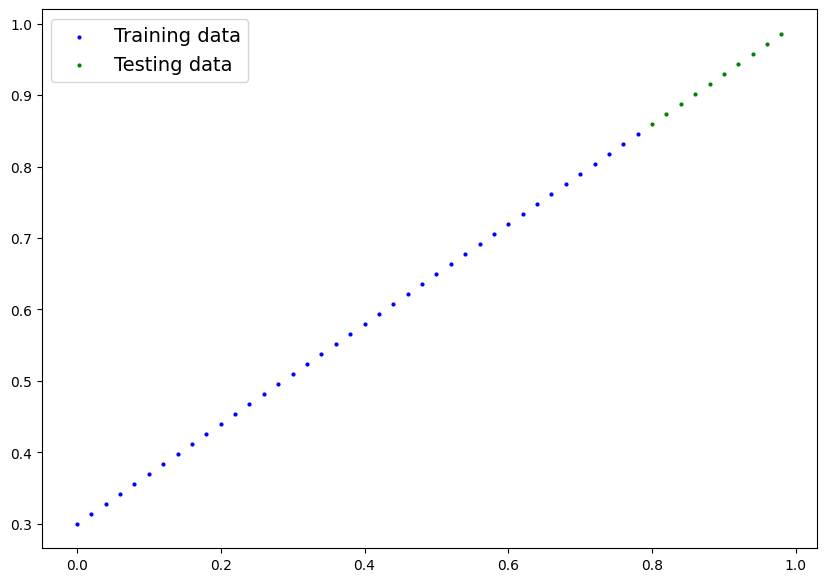

In [209]:
# y = weight * x + bias
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
# What were shape and ndim again?
print (f"X.shape: {X.shape}")
print (f"X.ndim: {X.ndim}")
print (f"X:\n{X[:5]}...")
y = weight * X + bias
print (f"y:\n{X[-5:]}...")

# Create train/test split: 80% of data used for training set, 20% for testing.
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(
    f"X_train: {len(X_train)}, y_train: {len(y_train)}, X_test: {len(X_test)}, y_test: {len(y_test)}"
)

plot_predictions(X_train, y_train, X_test, y_test)

Create a linear regression model.

model_0.parameters:
[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]

model_0.state_dict:
OrderedDict({'weights': tensor([0.3367]), 'bias': tensor([0.1288])})

Predicted values:
tensor([[0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])...
Error:
tensor([[0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])...


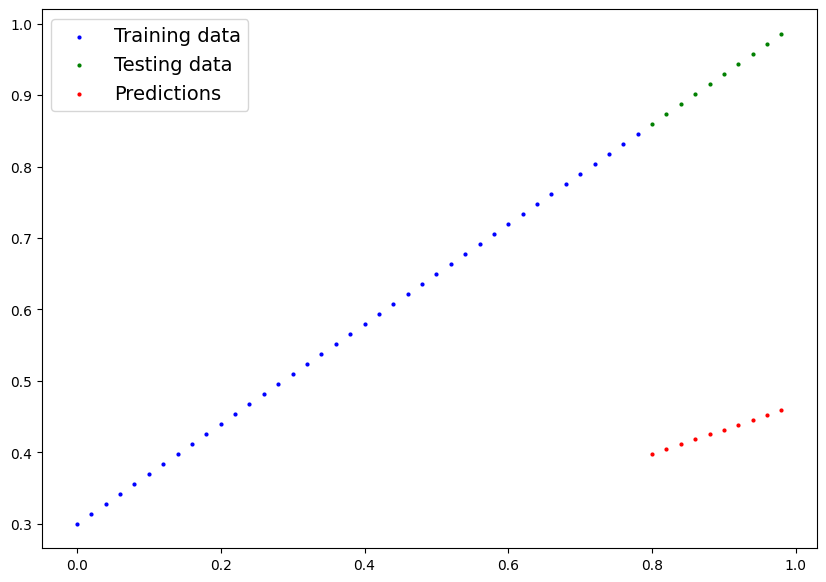

In [210]:
import torch.nn as nn


class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(
            torch.randn(
                1,  # Start with random weights (this will get adjusted as the model learns).
                dtype=torch.float,
            ),
            requires_grad=True,  # Can we update this value with gradient descent?
        )

        self.bias = nn.Parameter(
            torch.randn(
                1,  # Start with random bias (this will get adjusted as the model learns).
                dtype=torch.float,
            ),
            requires_grad=True,  # Can we update this value with gradient descent?
        )

    # Forward defines the computation in the model.
    def forward(
        self, x: torch.Tensor
    ) -> torch.Tensor:  # "x" is the input data (e.g. training/testing features).
        # This is the linear regression formula (y = m*x + b).
        return self.weights * x + self.bias


torch.manual_seed(SEED)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created.
print(f"model_0.parameters:\n{list(model_0.parameters())}\n")

# List named parameters.
print(f"model_0.state_dict:\n{model_0.state_dict()}\n")

# Make predictions with model.
with torch.inference_mode():
    y_preds = model_0(X_test)

# Check the predictions.
print(f"Predicted values:\n{y_preds[5:]}...")
print(f"Error:\n{(y_test - y_preds)[5:]}...")
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

Add a function for the training- and one for the testing loop.

In [211]:
def train_model(
    model: nn.Module, loss_fn: nn.Module, optimizer: torch.optim.Optimizer
) -> torch.Tensor:
    # Put model in training mode (this is the default state of a model).
    model.train()

    # 1. Forward pass on train data using the forward() method inside.
    y_pred = model(X_train)

    # 2. Calculate the loss (how different are our models predictions to the ground truth).
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer.
    optimizer.zero_grad()

    # 4. Loss backwards.
    loss.backward()

    # 5. Progress the optimizer.
    optimizer.step()

    return loss


def test_model(model: nn.Module, loss_fn: nn.Module) -> torch.Tensor:
    # Put the model in evaluation mode.
    model.eval()

    with torch.inference_mode():
        # 1. Forward pass on test data.
        test_pred = model(X_test)

        # 2. Caculate loss on test data.
        loss = loss_fn(
            # Predictions come in torch.float datatype, so comparisons need to be done with
            # tensors of the same type.
            test_pred,
            y_test.type(torch.float),
        )

        return loss



Train the model to hopefully make better predictions. 

For regression problems an L1 loss function with a stochastic gradient descent optimizer can be used.

Epoch: 0 | MAE Train Loss: 0.31288135051727295 | MAE Test Loss: 0.48106518387794495
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729658544063568
Epoch: 40 | MAE Train Loss: 0.04543796926736832 | MAE Test Loss: 0.11360953003168106
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484
Epoch: 100 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262
Epoch: 120 | MAE Train Loss: 0.01758546754717827 | MAE Test Loss: 0.04060482606291771
Epoch: 140 | MAE Train Loss: 0.010716589167714119 | MAE Test Loss: 0.024059748277068138
Epoch: 160 | MAE Train Loss: 0.003851776709780097 | MAE Test Loss: 0.008201557211577892
Epoch: 180 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss: 0.005023092031478882
Epoch: 200 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss: 0.005023092031478882
Epoch: 220 | MAE Train Loss: 0.008932482451200485 |

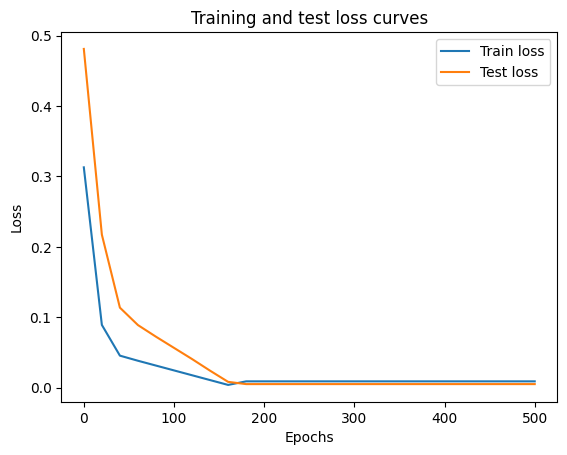

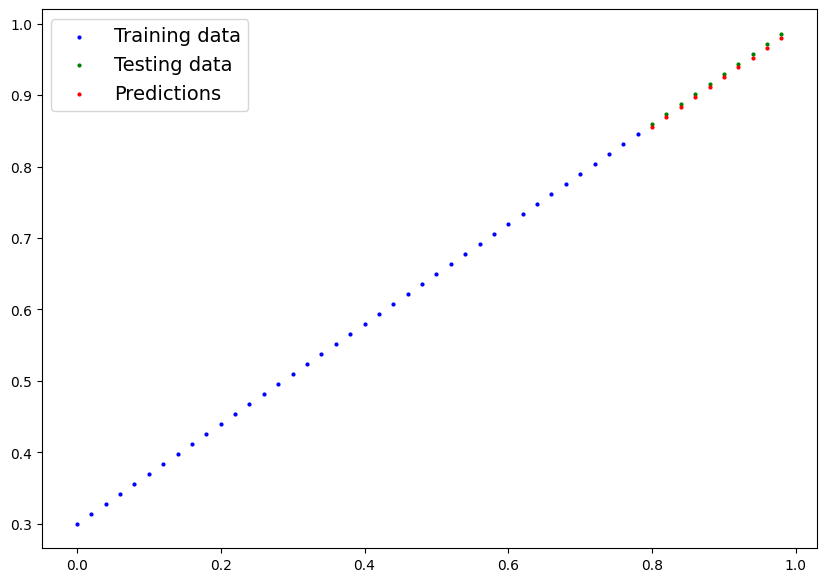

Error:
tensor([[0.0046],
        [0.0047],
        [0.0048],
        [0.0049],
        [0.0050],
        [0.0051],
        [0.0052],
        [0.0053],
        [0.0054],
        [0.0055]], device='cuda:0')


In [212]:
torch.manual_seed(SEED)

# Recreate the model.
model_0 = LinearRegressionModel()

# Create the loss function. Mean average error (MAE) loss is same as L1Loss.
loss_fn = nn.L1Loss()

# Create the optimizer.
optimizer = torch.optim.SGD(
    # Parameters of target model to optimize.
    params=model_0.parameters(),
    # Learning rate (how much the optimizer should change parameters at each step,
    # higher=more (less stable), lower=less (might take a long time).
    lr=0.01,
)

# Set the number of epochs (how many times the model will pass over the training data).
epochs = 500

# Send the model to the target device (GPU or CPU).
model_0.to(device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Create empty loss lists to track values.
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs + 1):
    # Train the model.
    loss = train_model(model_0, loss_fn, optimizer)
    # Test the model.
    # Note: we don't need to pass the optimizer to the test function since we are not updating the
    # model parameters.
    test_loss = test_model(model_0, loss_fn)

    # Print out what's happening.
    with torch.inference_mode():
        if epoch % 20 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().cpu().numpy())
            test_loss_values.append(test_loss.detach().cpu().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")


# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# Make predictions with the trained model.
with torch.inference_mode():
    y_preds = model_0(X_test)

plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), y_preds.cpu())

print(f"Error:\n{(y_test - y_preds)}")